In [95]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report
%matplotlib inline

In [96]:
torch.cuda.is_available()

False

In [3]:
tok = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', use_fast=False)
#model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')


In [4]:
#inputs = tok(['hälsa hälsan hälsans'], return_tensors="pt", padding='max_length', max_length = 512, truncation=True)
#inputs = tok(X[:10].values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [5]:
#outputs = model(**inputs)
#outputs = outputs['pooler_output'].detach().numpy().reshape(X.shape[0], -1)

In [45]:
class NLPTransformer(TransformerMixin):
    def __init__(self):
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.batch_size = 10
        
    def fit(self, X, y=None):
        print('Fit called')
        
        
        return self
    
    def partial_fit(self, X, y=None):
        print('Partial Fit called')

        return self
        
    def transform(self, X):
        print('Transform Called')
       
        # Transform input tokens. This is most efficient if done in one batch 
        inputs = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

        # Run Bert model, We must mini batch this in order to not overflow the memory of the system
        transformed = []
        
        batches = int(np.ceil(X.shape[0] / self.batch_size))
        for batchId in range(batches):
            print(f'Running batch {batchId+1}/{batches}')
        
            inputs_batch = {}
            for key in inputs.keys():
                inputs_batch[key] = inputs[key][batchId * self.batch_size:(batchId + 1) * self.batch_size]

            outputs = self.Bert(**inputs_batch)
            outputs = outputs['pooler_output'].detach().numpy()
            print(f'output shape: {outputs.shape}')
            transformed.extend(outputs)
        
        transformed = np.array(transformed)
        print(f'transformed.shape: {transformed.shape}')
        
        return transformed

In [46]:
pipeline = Pipeline([    
            ('nlpTransformer', NLPTransformer()),
            ('clf', RandomForestClassifier())])

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
#Read the data

In [97]:
#Test data anonymized
#df = pd.read_csv('../data/CRMIncidents_Anonymized.csv')
df = pd.read_csv('../data/CRMIncidents_Anonymized_Complete_Table.csv')

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (1,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,41,43,45,47,49,51,52,54,56,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [98]:
df.head()

,Unnamed: 0,Unnamed: 0.1,CRMIncidentId,IncidentId,LineId,Linje,JourneyId,TurNummer,Trafikslag,Ankomstdag,...,Enhet,Queue_SK,Kö,ModifiedOn,ContactId,Contact_SK,iBID,IsActive,TicketId,Beskrivning_Anonymized
0,0,0,673326.0,77DE23B5-43D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-10-29 11:33:19,586769.0,C0BDFF48-2C0B-E811-80F1-005056B64D75,NaN,True,NaN,"Hej,\r\r\n \r\r\nHar nu fått tag i föraren som..."
1,1,1,673354.0,EBD68435-41D8-E811-80F6-005056B63599,-1.0,NaN,-1.0,NaN,NaN,2018-10-25,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 08:17:09,331145.0,E429FD9A-5DEC-E411-80D6-0050569071BE,NaN,True,NaN,Buss 000 00:00\r\r\n\r\r\nKristianstad Hästtor...
2,2,2,673617.0,3ED0AA37-16D9-E811-80F4-005056B62B18,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2021-10-07 08:49:10,726145.0,12F4B35F-16D9-E811-80F4-005056B62B18,NaN,True,NaN,Skadeanmälan för påkörning av bil bakifrån vid...
3,3,3,673807.0,AAA91AC9-E0D8-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2018-11-08 10:36:12,603794.0,56A30A33-A32D-E811-80F2-005056B62B18,NaN,True,NaN,"Hej, \r\r\nVarför heter en av hållplatserna i ..."
4,4,4,673850.0,5F1165E6-63D9-E811-80F5-005056B64D75,-1.0,NaN,-1.0,NaN,NaN,2018-10-26,...,Kundtjänst,8.0,Support Synpunkter,2019-11-27 15:06:13,22229.0,383EAEB1-1DEB-E411-80D8-005056903A38,NaN,True,NaN,Hej!\r\r\nHar en fråga som gäller busskurerna ...


In [104]:
df.columns

Index(['Ärendetyp', 'Beskrivning_Anonymized', 'Prioritet', 'Ankomstdag'], dtype='object')

In [103]:
#Remove nans, select relevant columns
df = df[['Ärendetyp', 'Beskrivning_Anonymized', 'Prioritet', 'Ankomstdag']]
df = df[~df['Ärendetyp'].isna()]
df = df[~df['Beskrivning_Anonymized'].isna()]

(array([500., 500.,   0., 500.,   0., 500., 500.,   0., 500., 500.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

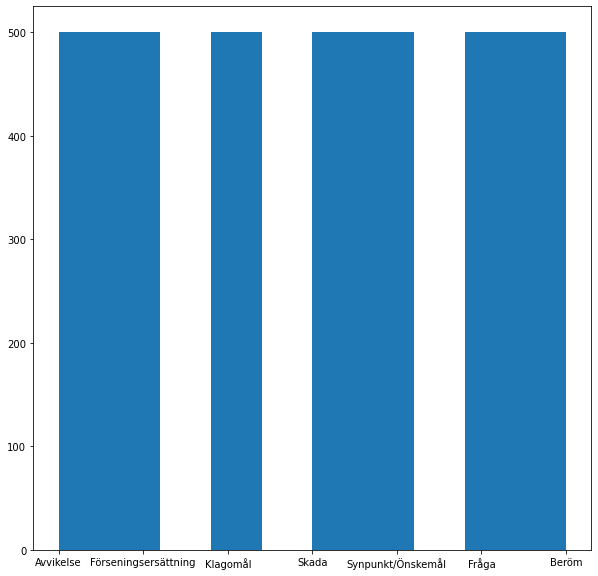

In [118]:
plt.figure(figsize=(10,10))
plt.hist(df['Ärendetyp'])

In [106]:
df[['Ärendetyp','Prioritet']].groupby(['Ärendetyp']).count()

,Prioritet
Ärendetyp,
Avvikelse,1325
Beröm,6057
Fråga,157997
Förseningsersättning,774415
Klagomål,281728
Skada,5194
Synpunkt/Önskemål,84305


In [108]:
df.shape

(1351467, 4)

In [109]:
categories = df['Ärendetyp'].unique()

In [110]:
categories

array(['Klagomål', 'Synpunkt/Önskemål', 'Skada', 'Fråga',
       'Förseningsersättning', 'Beröm', 'Avvikelse'], dtype=object)

In [117]:
#Make a balanced training set
desiredCount = 500
dfBalanced = None
for category in categories:
    sample = df[df['Ärendetyp'] == category].sample(n=desiredCount, replace=True, random_state=42)
    if dfBalanced is None:
        dfBalanced = sample
    else:
        dfBalanced = pd.concat([dfBalanced, sample], ignore_index=True)


#Next random shuffle of all rows
df = dfBalanced.sample(frac=1)

In [235]:
df = df[:10000] #Max for this computer
df.shape

2      Skada
6      Skada
21     Skada
43     Skada
70     Skada
222    Skada
239    Skada
240    Skada
282    Skada
331    Skada
Name: Ärendetyp, dtype: object

In [119]:
X = df['Beskrivning_Anonymized'].str.lower() #Lower case to slim the vocabulary

In [120]:
Y = pd.get_dummies(df['Ärendetyp'], columns=['Ärendetyp'])

In [121]:
classes = Y.columns

In [122]:
classes

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [123]:
Y.shape

(3500, 7)

In [124]:
#Note in case of pytorch CrossEntropyLoss, the targets should be the class index, not one hot encoded
Y = Y.values.argmax(axis=1)


In [125]:
Y

array([0, 3, 4, ..., 5, 6, 4], dtype=int64)

In [126]:
Y.max()

6

In [62]:
#This could also be a target
Y2 = pd.get_dummies(df['Prioritet'], columns=['Prioritet'])

In [63]:
Y2.head()

,Hög,Normal
0,0,1
1,0,1
2,1,0
3,0,1
4,0,1


In [21]:
X.head()

0    hej,\r\n \r\nhar nu fått tag i föraren som är ...
1    buss 000 00:00\r\n\r\nkristianstad hästtorget ...
2    skadeanmälan för påkörning av bil bakifrån vid...
3    hej, \r\nvarför heter en av hållplatserna i lu...
4    hej!\r\nhar en fråga som gäller busskurerna i ...
Name: Beskrivning_Anonymized, dtype: object

In [22]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [23]:
Y.head()

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0


In [24]:
inputs = tok('hej, Har nu fått tag i föraren som är', return_tensors="pt", padding='max_length', max_length = 512, truncation=True)

In [25]:
inputs

{'input_ids': tensor([[    2,  8819,    19,  1177,   346,   902,  1326,    31, 15367,    67,
            54,     3,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [12]:
#Test train split

In [127]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [128]:
X_train.shape

(2800,)

In [129]:
Y_train[:5]

array([3, 5, 3, 3, 0], dtype=int64)

In [130]:
class MiniBatcher():
    def __init__(self, X, Y, batch_size=100, max_epochs=1):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.batchId = 0
        self.epochId = 0
        
    def getBatchIterator(self):
        self.batchId = 0
        self.epochId = 0
        
        while True:
            X_mini = self.X[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            Y_mini = self.Y[self.batchId * self.batch_size:(self.batchId + 1) * self.batch_size]
            self.batchId += 1
            print(self.batchId, self.epochId)
            print(len(X_mini))
            if len(X_mini) < self.batch_size:
                self.epochId += 1
                self.batchId = 0
                if self.epochId <= self.max_epochs:
                    print('will break')
                    break
            
            yield X_mini, Y_mini
            


In [30]:
mMiniBatcher = MiniBatcher(X_train, Y_train)

In [31]:
batchIterator = mMiniBatcher.getBatchIterator()

In [16]:
#Train the model
#output = pipeline.fit(X_train[:25], Y_train[:25].values)
#output = pipeline.fit(X_train[:1500], Y_train[:1500].values)
output = pipeline.fit(X_train, Y_train.values)

Fit called
Transform Called
Running batch 1/800
output shape: (10, 768)
Running batch 2/800
output shape: (10, 768)
Running batch 3/800
output shape: (10, 768)
Running batch 4/800
output shape: (10, 768)
Running batch 5/800
output shape: (10, 768)
Running batch 6/800
output shape: (10, 768)
Running batch 7/800
output shape: (10, 768)
Running batch 8/800
output shape: (10, 768)
Running batch 9/800
output shape: (10, 768)
Running batch 10/800
output shape: (10, 768)
Running batch 11/800
output shape: (10, 768)
Running batch 12/800
output shape: (10, 768)
Running batch 13/800
output shape: (10, 768)
Running batch 14/800
output shape: (10, 768)
Running batch 15/800
output shape: (10, 768)
Running batch 16/800
output shape: (10, 768)
Running batch 17/800
output shape: (10, 768)
Running batch 18/800
output shape: (10, 768)
Running batch 19/800
output shape: (10, 768)
Running batch 20/800
output shape: (10, 768)
Running batch 21/800
output shape: (10, 768)
Running batch 22/800
output shape: (

output shape: (10, 768)
Running batch 182/800
output shape: (10, 768)
Running batch 183/800
output shape: (10, 768)
Running batch 184/800
output shape: (10, 768)
Running batch 185/800
output shape: (10, 768)
Running batch 186/800
output shape: (10, 768)
Running batch 187/800
output shape: (10, 768)
Running batch 188/800
output shape: (10, 768)
Running batch 189/800
output shape: (10, 768)
Running batch 190/800
output shape: (10, 768)
Running batch 191/800
output shape: (10, 768)
Running batch 192/800
output shape: (10, 768)
Running batch 193/800
output shape: (10, 768)
Running batch 194/800
output shape: (10, 768)
Running batch 195/800
output shape: (10, 768)
Running batch 196/800
output shape: (10, 768)
Running batch 197/800
output shape: (10, 768)
Running batch 198/800
output shape: (10, 768)
Running batch 199/800
output shape: (10, 768)
Running batch 200/800
output shape: (10, 768)
Running batch 201/800
output shape: (10, 768)
Running batch 202/800
output shape: (10, 768)
Running ba

output shape: (10, 768)
Running batch 361/800
output shape: (10, 768)
Running batch 362/800
output shape: (10, 768)
Running batch 363/800
output shape: (10, 768)
Running batch 364/800
output shape: (10, 768)
Running batch 365/800
output shape: (10, 768)
Running batch 366/800
output shape: (10, 768)
Running batch 367/800
output shape: (10, 768)
Running batch 368/800
output shape: (10, 768)
Running batch 369/800
output shape: (10, 768)
Running batch 370/800
output shape: (10, 768)
Running batch 371/800
output shape: (10, 768)
Running batch 372/800
output shape: (10, 768)
Running batch 373/800
output shape: (10, 768)
Running batch 374/800
output shape: (10, 768)
Running batch 375/800
output shape: (10, 768)
Running batch 376/800
output shape: (10, 768)
Running batch 377/800
output shape: (10, 768)
Running batch 378/800
output shape: (10, 768)
Running batch 379/800
output shape: (10, 768)
Running batch 380/800
output shape: (10, 768)
Running batch 381/800
output shape: (10, 768)
Running ba

output shape: (10, 768)
Running batch 540/800
output shape: (10, 768)
Running batch 541/800
output shape: (10, 768)
Running batch 542/800
output shape: (10, 768)
Running batch 543/800
output shape: (10, 768)
Running batch 544/800
output shape: (10, 768)
Running batch 545/800
output shape: (10, 768)
Running batch 546/800
output shape: (10, 768)
Running batch 547/800
output shape: (10, 768)
Running batch 548/800
output shape: (10, 768)
Running batch 549/800
output shape: (10, 768)
Running batch 550/800
output shape: (10, 768)
Running batch 551/800
output shape: (10, 768)
Running batch 552/800
output shape: (10, 768)
Running batch 553/800
output shape: (10, 768)
Running batch 554/800
output shape: (10, 768)
Running batch 555/800
output shape: (10, 768)
Running batch 556/800
output shape: (10, 768)
Running batch 557/800
output shape: (10, 768)
Running batch 558/800
output shape: (10, 768)
Running batch 559/800
output shape: (10, 768)
Running batch 560/800
output shape: (10, 768)
Running ba

output shape: (10, 768)
Running batch 719/800
output shape: (10, 768)
Running batch 720/800
output shape: (10, 768)
Running batch 721/800
output shape: (10, 768)
Running batch 722/800
output shape: (10, 768)
Running batch 723/800
output shape: (10, 768)
Running batch 724/800
output shape: (10, 768)
Running batch 725/800
output shape: (10, 768)
Running batch 726/800
output shape: (10, 768)
Running batch 727/800
output shape: (10, 768)
Running batch 728/800
output shape: (10, 768)
Running batch 729/800
output shape: (10, 768)
Running batch 730/800
output shape: (10, 768)
Running batch 731/800
output shape: (10, 768)
Running batch 732/800
output shape: (10, 768)
Running batch 733/800
output shape: (10, 768)
Running batch 734/800
output shape: (10, 768)
Running batch 735/800
output shape: (10, 768)
Running batch 736/800
output shape: (10, 768)
Running batch 737/800
output shape: (10, 768)
Running batch 738/800
output shape: (10, 768)
Running batch 739/800
output shape: (10, 768)
Running ba

In [17]:
output.predict(X_test[:10])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


array([[0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [135]:
probs = output.predict_proba(X_test[:15])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (5, 768)
transformed.shape: (15, 768)


In [53]:
Y_test[:3].values

array([[0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [75]:
Y_test[:15]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
521,0,0,1,0,0,0,0
941,0,0,0,0,0,0,1
741,0,0,1,0,0,0,0
980,0,0,0,0,0,0,1
411,0,0,0,0,0,0,1
679,0,0,1,0,0,0,0
673,0,0,0,0,0,0,1
513,0,0,0,0,1,0,0
773,0,0,0,0,1,0,0
136,0,0,0,0,0,0,1


In [24]:
#This will predict the classes for each row. The class with the highest probability is selected
def PredictClasses(model, X):
    probs = model.predict_proba(X)
    probs = np.array(probs) #List to (N, num_classes, 2)
    predictedClasses = np.argmax(probs[:,:,1].T, axis=1) #First index classifies it as 0, second as 1, Then get the max index for each row
    
    return predictedClasses
    
    
    

In [105]:
X[3]

'hej, \r\nvarför heter en av hållplatserna i ludvigsborg kvarndamms gatan i hörby kommun, skåne? dels så finns det ingen väg som heter så där, den heter kvarndamsvägen. dessutom är hållplatsen på ludvigsborgsvägen. xxxx ni vidarebefordra detta till rätt avdelning så det blir ändrat för att inte göra det förvirrat för resenärerna?\r\nhälsningar fredrik\r\r\n'

In [31]:
result = PredictClasses(pipeline, X_test[10:20])

Transform Called
Running batch 1/1
output shape: (10, 768)
transformed.shape: (10, 768)


In [29]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2], dtype=int64)

In [32]:
Y_test[10:20]

,Avvikelse,Beröm,Fråga,Förseningsersättning,Klagomål,Skada,Synpunkt/Önskemål
2750,0,0,0,1,0,0,0
7487,0,0,0,1,0,0,0
5272,0,0,0,1,0,0,0
5653,0,0,0,1,0,0,0
3999,0,0,0,1,0,0,0
6033,0,0,0,1,0,0,0
582,0,0,0,0,1,0,0
9930,0,0,0,1,0,0,0
7051,0,0,0,1,0,0,0
8158,0,0,0,1,0,0,0


In [38]:
result

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 3], dtype=int64)

In [41]:
ost = Y_test[10:20].to_numpy().argmax(axis=1)
ost

array([3, 3, 3, 3, 3, 3, 4, 3, 3, 3], dtype=int64)

In [51]:
result.shape

(10,)

In [77]:
cm = confusion_matrix(ost, result,normalize='true')
cm

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

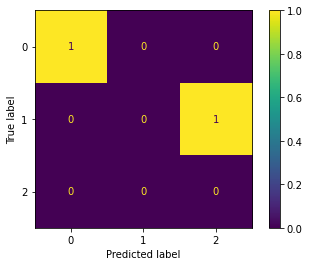

In [78]:
ConfusionMatrixDisplay(confusion_matrix=cm,).plot()

In [61]:
confusion_matrix(ost, result)

array([[9, 0, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=int64)

In [62]:
#results = PredictClasses(pipeline, X_test[:15])
results = PredictClasses(pipeline, X_test)
results

Transform Called
Running batch 1/200


KeyboardInterrupt: 

In [85]:
results

array([4, 6, 4, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 2, 4, 6, 6, 2,
       2, 4, 4, 4, 4, 6, 2, 4, 4, 6, 6, 6, 4, 4, 6, 2, 6, 4, 4, 4, 3, 6,
       4, 6, 2, 6, 2, 6, 6, 2, 6, 6, 4, 6, 4, 4, 4, 6, 4, 4, 4, 6, 6, 6,
       6, 2, 4, 6, 6, 6, 6, 6, 4, 4, 2, 4, 6, 4, 6, 4, 2, 6, 4, 2, 6, 6,
       2, 2, 4, 4, 4, 4, 6, 4, 4, 4, 4, 6, 6, 4, 4, 2, 2, 6, 4, 4, 3, 6,
       6, 4, 6, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 2, 4, 6, 6, 4, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 6, 4, 4, 6, 6, 4, 6, 2, 6, 4, 2, 4, 4, 2, 6, 2,
       6, 6, 2, 6, 4, 6, 6, 4, 6, 6, 2, 6, 4, 6, 3, 4, 4, 4, 2, 6, 4, 4,
       6, 2, 6, 2, 4, 6, 4, 2, 6, 2, 4, 6, 6, 6, 4, 6, 6, 4, 2, 6, 6, 2,
       6, 2, 6], dtype=int64)

In [89]:
targets = np.argmax(np.array(Y), axis=1)
targets

array([4, 6, 5, ..., 4, 4, 2], dtype=int64)

In [34]:
Y_test.columns

Index(['Avvikelse', 'Beröm', 'Fråga', 'Förseningsersättning', 'Klagomål',
       'Skada', 'Synpunkt/Önskemål'],
      dtype='object')

In [79]:
def EvaluateModelUsingProbs(model, X_test, Y_test):
    Y_pred = PredictClasses(model, X_test) #1D-array with classes
    targets = np.argmax(np.array(Y_test), axis=1) #1D-array with classes
    
    total_hits = np.sum(np.sum(Y_pred == targets))
    total_misses = np.sum(np.sum(Y_pred != targets))
    total_accuracy = total_hits/(total_hits + total_misses)
    print(f'Total Accuracy: {total_accuracy}')
    cm = confusion_matrix(targets, Y_pred, normalize='true')
    ConfusionMatrixDisplay(confusion_matrix=cm,).plot()
    

In [22]:
#Evaluate the model and print the accuracy

def EvaluateModel(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    
    total_hits = np.sum(np.sum(Y_pred == Y_test))
    total_misses = np.sum(np.sum(Y_pred != Y_test))
    total_accuracy = total_hits/(total_hits + total_misses)
       
    target_names = [name for name in Y.columns]

    precisions = []
    recalls = []
    f1scores = []
    for (name, col) in zip(target_names, range(len(target_names))):
        y_test = Y_test[name].values
        y_pred = Y_pred[:, col]
        
        if(np.max(y_test) <= 1):
            #Only one category
            precisions.append(precision_score(y_test, y_pred))
            recalls.append(recall_score(y_test, y_pred))
            f1scores.append(f1_score(y_test, y_pred))
        print(f'Category: {name}')
        print(classification_report(y_test, y_pred))
        print('-'*42)
     
    
    print(f'Total Accuracy: {total_accuracy}')
    print(f'Average Precission: {np.average(precisions)}')
    print(f'Average Recall: {np.average(recalls)}')
    print(f'Average F1 Score: {np.average(f1scores)}')

In [88]:
EvaluateModel(pipeline, X_test[:100], Y_test[:100])

Transform Called
Running batch 1/10
output shape: (10, 768)
Running batch 2/10
output shape: (10, 768)
Running batch 3/10
output shape: (10, 768)
Running batch 4/10
output shape: (10, 768)
Running batch 5/10
output shape: (10, 768)
Running batch 6/10
output shape: (10, 768)
Running batch 7/10
output shape: (10, 768)
Running batch 8/10
output shape: (10, 768)
Running batch 9/10
output shape: (10, 768)
Running batch 10/10
output shape: (10, 768)
transformed.shape: (100, 768)
Category: Avvikelse
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

------------------------------------------
Category: Beröm
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        99
           1       0.00      0.00      0.00         1

    ac

C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
C:\ProgramData\Anaconda3\envs\dataScience\lib\site-

Transform Called
Running batch 1/60
output shape: (10, 768)
Running batch 2/60
output shape: (10, 768)
Running batch 3/60
output shape: (10, 768)
Running batch 4/60
output shape: (10, 768)
Running batch 5/60
output shape: (10, 768)
Running batch 6/60
output shape: (10, 768)
Running batch 7/60
output shape: (10, 768)
Running batch 8/60
output shape: (10, 768)
Running batch 9/60
output shape: (10, 768)
Running batch 10/60
output shape: (10, 768)
Running batch 11/60
output shape: (10, 768)
Running batch 12/60
output shape: (10, 768)
Running batch 13/60
output shape: (10, 768)
Running batch 14/60
output shape: (10, 768)
Running batch 15/60
output shape: (10, 768)
Running batch 16/60
output shape: (10, 768)
Running batch 17/60
output shape: (10, 768)
Running batch 18/60
output shape: (10, 768)
Running batch 19/60
output shape: (10, 768)
Running batch 20/60
output shape: (10, 768)
Running batch 21/60
output shape: (10, 768)
Running batch 22/60
output shape: (10, 768)
Running batch 23/60
outp

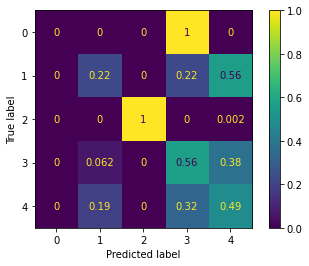

In [82]:
EvaluateModelUsingProbs(pipeline, X_test[:600], Y_test[:600])

In [108]:
EvaluateModelUsingProbs(pipeline, X_train, Y_train)

Transform Called
Running batch 1/80
output shape: (10, 768)
Running batch 2/80
output shape: (10, 768)
Running batch 3/80
output shape: (10, 768)
Running batch 4/80
output shape: (10, 768)
Running batch 5/80
output shape: (10, 768)
Running batch 6/80
output shape: (10, 768)
Running batch 7/80
output shape: (10, 768)
Running batch 8/80
output shape: (10, 768)
Running batch 9/80
output shape: (10, 768)
Running batch 10/80
output shape: (10, 768)
Running batch 11/80
output shape: (10, 768)
Running batch 12/80
output shape: (10, 768)
Running batch 13/80
output shape: (10, 768)
Running batch 14/80
output shape: (10, 768)
Running batch 15/80
output shape: (10, 768)
Running batch 16/80
output shape: (10, 768)
Running batch 17/80
output shape: (10, 768)
Running batch 18/80
output shape: (10, 768)
Running batch 19/80
output shape: (10, 768)
Running batch 20/80
output shape: (10, 768)
Running batch 21/80
output shape: (10, 768)
Running batch 22/80
output shape: (10, 768)
Running batch 23/80
outp

In [130]:
y.iloc[0:10].values

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]], dtype=uint8)

In [140]:
#Save, Load model

In [2]:
from joblib import dump, load

In [15]:
modelName = 'BertModel.joblib'

In [142]:

dump(pipeline, modelName ) 

['BertModel.joblib']

In [18]:
loadedModel = load(modelName) 

In [19]:
loadedModel.predict(X_test[100:120])

Transform Called
Running batch 1/2
output shape: (10, 768)
Running batch 2/2
output shape: (10, 768)
transformed.shape: (20, 768)


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [1]:
#Deep learning using pytorch

In [131]:
from torch import nn, optim
import torch.nn.functional as F

class TorchNLP(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        print('Init called')
        self.model_name = 'KB/bert-base-swedish-cased'
        self.Bert = AutoModel.from_pretrained(self.model_name)
        self.Tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.n_classes = n_classes
        self.TorchModel = nn.Sequential(nn.Linear(768, 128),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),
                          nn.Linear(128, 64),
                          nn.ReLU(),
                          nn.Dropout(p=0.2),              
                          nn.Linear(64, n_classes))
                          #nn.Softmax(dim=1)) Cannot use softmax here since nn.CrossEntropyLoss expects scores!
        
        #Freeze the Bert model layers
        for param in self.Bert.parameters():
            param.requires_grad = False
            
    def forward(self, X):
        print('Forward Called')
       
        #Check device
        device = self.Bert.device
        
        # Transform input tokens. This is most efficient if done in one batch 
        X = self.Tokenizer(X.values.tolist(), return_tensors="pt", padding='max_length', max_length = 512, truncation=True).to(device)
        
        X = self.Bert(**X)
        X = X['pooler_output']
        X = self.TorchModel(X)
        
        return X
    
    def predict(self, X):
        with torch.no_grad():
            self.eval()
            output = torchModel(X)
            top_p, top_class = output.topk(1, dim=1)
            top_class = top_class.to('cpu').numpy().reshape(-1,)
            self.train()
            return top_class

In [132]:
torchModel.Bert.device

device(type='cpu')

In [97]:
Y.max()

6

In [133]:
#n_classes = Y.shape[1] #In case of one hot encoded, which we don't have anymore
n_classes = Y.max() + 1
torchModel = TorchNLP(n_classes = n_classes)

Init called


Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [67]:
output = torchModel(X_train[:5])

Forward Called


In [68]:
output

tensor([[0.1394, 0.1599, 0.1548, 0.1324, 0.1248, 0.1408, 0.1479],
        [0.1428, 0.1565, 0.1440, 0.1306, 0.1277, 0.1471, 0.1513],
        [0.1410, 0.1569, 0.1521, 0.1396, 0.1235, 0.1379, 0.1489],
        [0.1318, 0.1499, 0.1585, 0.1312, 0.1373, 0.1510, 0.1404],
        [0.1423, 0.1517, 0.1463, 0.1242, 0.1348, 0.1532, 0.1476]],
       grad_fn=<SoftmaxBackward0>)

In [134]:
mMiniBatcherTrain = MiniBatcher(X_train[:1000], Y_train[:1000], batch_size=15)
mMiniBatcherTest = MiniBatcher(X_test[:100], Y_test[:100], batch_size=15)

In [70]:
for param in torchModel.parameters():
    print(type(param.data), param.size(), param.requires_grad)

<class 'torch.Tensor'> torch.Size([50325, 768]) False
<class 'torch.Tensor'> torch.Size([512, 768]) False
<class 'torch.Tensor'> torch.Size([2, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768, 768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([3072, 768]) False
<class 'torch.Tensor'> torch.Size([3072]) False
<class 'torch.Tensor'> torch.Size([768, 3072]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torch.Tensor'> torch.Size([768]) False
<class 'torc

In [135]:
cuda_enabled = torch.cuda.is_available()
if cuda_enabled:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(f'We are running on device: {device}')

We are running on device: cpu


In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(torchModel.parameters(), lr=0.003)
#optimizer = optim.Adam(torchModel.parameters(), lr=0.0015)
optimizer = optim.Adam(torchModel.TorchModel.parameters(), lr=0.0015)

epochs = 15
steps = 0
train_losses, test_losses = [], []

torchModel.to(device)
#optimizer.to(device)
criterion.to(device)

for e in range(epochs):
    running_loss = 0
    for images, labels in mMiniBatcherTrain.getBatchIterator():
        print('Training batch...')
        optimizer.zero_grad()
 
        print(f'labels.shape: {labels.shape}')
        labels = torch.from_numpy(labels).to(device)
        
        print('Running torch')
        output = torchModel(images)
        
        print(f'output.shape: {output.shape}')
        print('Calculating loss')
        
        loss = criterion(output, labels)
        print('Back prop.')
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        print(f'Batch loss: {batch_loss}')
        running_loss += batch_loss
        
   
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        torchModel.eval()
        for images, labels in mMiniBatcherTest.getBatchIterator():
            print('Validation batch...')
            #labels = torch.from_numpy(labels.values).type(torch.FloatTensor)
            labels = torch.from_numpy(labels).to(device)
            output = torchModel(images)
            test_loss += criterion(output, labels).to('cpu') #Want the loss on CPU

            top_p, top_class = output.topk(1, dim=1)
            print(top_p)
            #top_p_target, top_class_target = labels.topk(1, dim=1)
            #equals = top_class == top_class_target
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.sum(equals.type(torch.FloatTensor)).to('cpu')

    torchModel.train()

    train_losses.append(running_loss/len(mMiniBatcherTrain.X))
    test_losses.append(test_loss/len(mMiniBatcherTest.X))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Test Loss: {:.3f}.. ".format(test_losses[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(mMiniBatcherTest.X)))

1 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.958450436592102
2 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.9060595035552979
3 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.985826849937439
4 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 2.085007905960083
5 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.8747038841247559
6 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.973071575164795
7 

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.7214264869689941
51 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.2700668573379517
52 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.5550719499588013
53 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.343803882598877
54 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.606683611869812
55 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0807957649230957
56 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward C

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.4511278867721558
22 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.4259532690048218
23 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.5342037677764893
24 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.6090754270553589
25 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.3205260038375854
26 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0317491292953491
27 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward

tensor([[2.2363],
        [3.8647],
        [2.0711],
        [1.7855],
        [1.6157],
        [1.7273],
        [1.0524],
        [2.1171],
        [1.1199],
        [1.7293],
        [2.1216],
        [5.9241],
        [0.9191],
        [1.0923],
        [1.4260]])
4 0
15
Validation batch...
Forward Called
tensor([[6.0802],
        [1.7593],
        [1.3242],
        [1.2780],
        [5.8041],
        [2.5551],
        [2.1412],
        [1.0127],
        [1.8994],
        [1.8478],
        [4.2533],
        [0.7732],
        [0.9716],
        [5.5559],
        [1.5765]])
5 0
15
Validation batch...
Forward Called
tensor([[0.8460],
        [1.9556],
        [1.1767],
        [6.4056],
        [3.3949],
        [0.7841],
        [3.4124],
        [1.1188],
        [1.3292],
        [2.4385],
        [1.5806],
        [2.2265],
        [1.4723],
        [2.0251],
        [1.2082]])
6 0
15
Validation batch...
Forward Called
tensor([[6.1852],
        [6.0295],
        [1.4400],
       

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.975085973739624
43 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.1142665147781372
44 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.1490838527679443
45 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.1769322156906128
46 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.4234572649002075
47 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0413786172866821
48 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward 

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0353789329528809
14 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9571688175201416
15 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.758428156375885
16 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8530927896499634
17 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0057755708694458
18 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6143478751182556
19 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward 

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8845073580741882
63 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.3719502687454224
64 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.762408971786499
65 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6884971261024475
66 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8650992512702942
67 0
10
will break
1 0
15
Validation batch...
Forward Called
tensor([[1.2912],
        [7.4999],
        [1.9072],
        [1.2809],
        [1.4933],
        [2.0255],
        [6.7634],
        [4.2709],
        [6.5521],
        [1.22

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.1718238592147827
34 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.183066725730896
35 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.619390606880188
36 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0960299968719482
37 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.7769448161125183
38 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9079605340957642
39 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward C

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.38439884781837463
5 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9698538184165955
6 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6624902486801147
7 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8265892267227173
8 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8178777098655701
9 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0431277751922607
10 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Cal

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9920731782913208
54 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.5486387014389038
55 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.47173500061035156
56 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6261276602745056
57 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.5215054154396057
58 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6775394678115845
59 0
15
Training batch...
labels.shape: (15,)
Running torch
Forwar

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9369651079177856
25 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.7062095999717712
26 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.5132995247840881
27 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8071895837783813
28 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8033307790756226
29 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.664925456047058
30 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward 

tensor([[4.3579],
        [3.1463],
        [1.6751],
        [8.7267],
        [6.3968],
        [0.9913],
        [3.6402],
        [1.6871],
        [1.5957],
        [4.1974],
        [0.9907],
        [3.7083],
        [2.2485],
        [1.3010],
        [1.8022]])
6 0
15
Validation batch...
Forward Called
tensor([[8.3655],
        [8.8382],
        [1.6653],
        [2.5969],
        [8.1278],
        [1.5485],
        [8.9529],
        [0.9028],
        [5.2321],
        [0.6127],
        [2.5660],
        [9.0470],
        [1.0971],
        [1.4457],
        [1.8554]])
7 0
10
will break
Epoch: 7/15..  Training Loss: 0.054..  Test Loss: 0.047..  Test Accuracy: 0.630
1 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 1.0529570579528809
2 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9879528284072876
47 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6519625782966614
48 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.946182906627655
49 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.9434266686439514
50 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6516208648681641
51 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.5341209769248962
52 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward 

output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.6792224645614624
18 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.4633333086967468
19 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.7716825604438782
20 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.7855471968650818
21 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8874412775039673
22 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward Called
output.shape: torch.Size([15, 7])
Calculating loss
Back prop.
Batch loss: 0.8300145864486694
23 0
15
Training batch...
labels.shape: (15,)
Running torch
Forward

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [156]:
torchModel.to('cpu')

TorchNLP(
  (Bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50325, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [165]:
torchModel.Bert.device

device(type='cuda', index=0)

In [166]:
torchModel(X_test[:25])

Forward Called


tensor([[-1.4626, -1.5387, -1.6581,  5.5220, -1.1519, -1.9339, -0.4945],
        [-2.4869, -2.2417, -0.1596,  5.9095, -0.8429, -2.5162, -0.1103],
        [-2.2634, -1.6346,  0.2437,  5.0969, -1.4610, -0.9196,  0.4518],
        [-1.4876, -2.0991, -1.3574,  5.9189, -0.3710, -3.3775, -0.0616],
        [-1.9867, -2.1058, -0.8074,  5.6330, -0.1044, -3.1820, -0.1562],
        [-2.2982, -2.8106, -0.7049,  5.6376, -0.9757, -1.1950, -0.0750],
        [-1.3132, -0.8251, -0.8038,  4.2634, -0.0722, -2.5963,  0.0976],
        [-1.7288, -1.0971, -0.2127,  5.4893, -1.3920, -1.5332,  0.2278],
        [-2.0425, -1.3268, -1.0715,  5.6121, -0.3769, -1.5521,  0.0577],
        [-1.2958, -1.1475, -0.4645,  3.3163, -0.1179, -1.1458, -0.0809],
        [-2.9055, -2.2610, -0.9447,  6.2404, -0.8267, -2.1755,  0.2848],
        [-2.0705, -1.8187, -1.2083,  5.5571, -0.0396, -2.7881,  0.2048],
        [-1.7872, -2.5268, -1.0414,  4.4269, -0.7507, -0.7875,  0.1495],
        [-2.2243, -2.2796, -0.6230,  5.6976, -1.015

In [213]:
Y_pred = []
targets = []
for X_batch, labels in mMiniBatcherTest.getBatchIterator():
  
        output = torchModel.predict(X_batch)
        Y_pred.extend(output)
        targets.extend(labels)


1 0
100
Forward Called
2 0
100
Forward Called
3 0
100
Forward Called
4 0
100
Forward Called
5 0
100
Forward Called
6 0
100
Forward Called
7 0
100
Forward Called
8 0
100
Forward Called
9 0
100
Forward Called
10 0
100
Forward Called
11 0
0
will break


In [224]:
Y_pred = np.array(Y_pred)
targets = np.array(targets)

In [225]:
#Y_pred = torchModel.predict(X_test[200:300])
Y_pred

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 6, 4, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       2, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3, 2, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 2, 3, 3, 6, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3,
       4, 3, 3, 3, 2, 3, 3, 6, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 6, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       2, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [226]:
#targets = Y_test[200:300]
targets

array([3, 3, 3, 3, 3, 3, 6, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3,
       3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 4, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       2, 3, 3, 3, 6, 3, 3, 3, 4, 3, 3, 2, 3, 3, 3, 6, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 3, 3, 4, 3, 3, 6, 3, 4, 3, 3, 3, 3, 2, 3, 3, 3, 2, 6,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 3, 3, 3, 3, 3, 6, 3,
       4, 3, 3, 3, 2, 3, 3, 4, 3, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 4, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3,
       2, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [228]:
accuracy = np.mean(Y_pred == targets)
print(f'Accuracy: {accuracy}')

Accuracy: 0.926


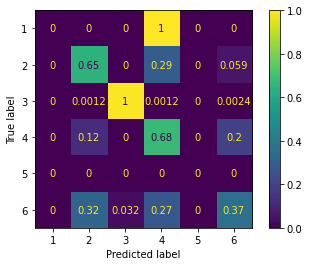

In [217]:
cm = confusion_matrix(targets, Y_pred, normalize='true', labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()

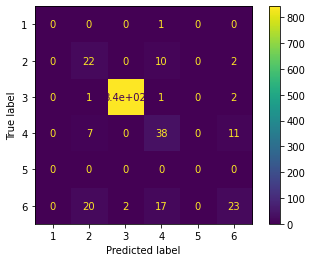

In [218]:
cm = confusion_matrix(targets, Y_pred, normalize=None, labels=list(set(Y_test)))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(set(Y_test))).plot()